In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects/neo_v2.csv
/kaggle/input/nasa-nearest-earth-objects/neo.csv


# The dataset

In [3]:
nasa_dataset = pd.read_csv('../input/nasa-nearest-earth-objects/neo.csv')
nasa_dataset.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
nasa_dataset.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [5]:
nasa_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
nasa_dataset.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

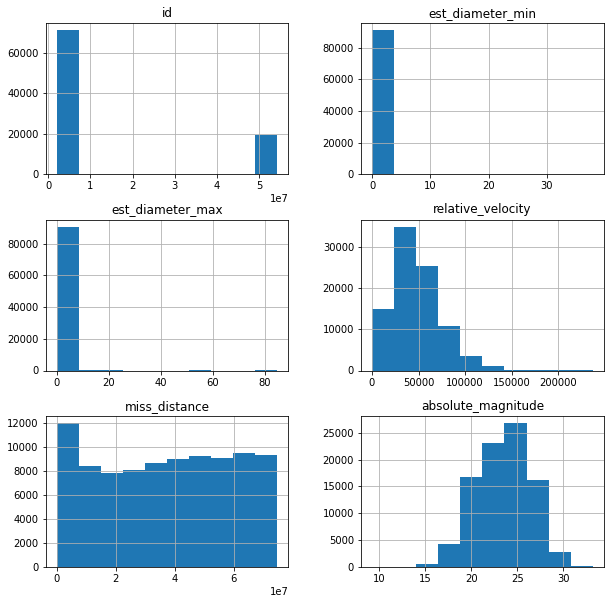

In [7]:
nasa_dataset.hist(figsize=(10, 10));

# Data pre-processing

In [8]:
features = nasa_dataset.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
features.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [9]:
targets = features['hazardous']
features = features.drop('hazardous', axis=1)
targets.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [10]:
targets = targets.map({
    False: 0,
    True: 1
}) 

targets.value_counts()

0    81996
1     8840
Name: hazardous, dtype: int64

In [11]:
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.031607,0.031607,0.056447,0.733141,0.312891
1,0.006999,0.006999,0.309922,0.821364,0.449312
2,0.019039,0.019039,0.481680,0.665740,0.358782
3,0.002531,0.002531,0.103726,0.339986,0.541093
4,0.006714,0.006714,0.179632,0.618634,0.453066


In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=42, test_size=0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((63585, 5), (63585,), (27251, 5), (27251,))

# Classification

## Decision Tree Classifier

In [13]:
decision_tree_parameters = [{
    'max_depth': range(1, 20)
}]
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), decision_tree_parameters)
grid_search_tree.fit(x_train, y_train)
print(grid_search_tree.best_params_)

{'max_depth': 4}


In [14]:
clf_tree = DecisionTreeClassifier(max_depth=4)

In [15]:
cross_val_tree = cross_val_score(clf_tree, x_test, y_test, cv=5)
print((cross_val_tree * 100).mean())

91.04986779633062


In [17]:
clf_tree.fit(x_train, y_train)
predict_tree = clf_tree.predict(x_test)
print(classification_report(y_test, predict_tree))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     24597
           1       0.84      0.11      0.19      2654

    accuracy                           0.91     27251
   macro avg       0.88      0.55      0.57     27251
weighted avg       0.91      0.91      0.88     27251



## Support Vector Machine(SVM)

In [19]:
svm_parameters = [{
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid', 'poly'],
    'degree': [1, 2, 3, 4],
    'gamma': ['scale', 'auto']
}]
randomized_search_svm = RandomizedSearchCV(SVC(), svm_parameters, n_iter=5, scoring='accuracy', cv=5)
randomized_search_svm.fit(x_train, y_train)
randomized_search_svm.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10}

In [20]:
clf_svm = SVC(C=10, gamma='scale', kernel='rbf')

In [21]:
cross_val_svm = cross_val_score(clf_svm, x_test, y_test, cv=5)
print((cross_val_svm * 100).mean())

90.8296903690763


In [22]:
clf_svm.fit(x_train, y_train)
predict_svm = clf_svm.predict(x_test)
print(classification_report(y_test, predict_svm))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     24597
           1       0.75      0.10      0.18      2654

    accuracy                           0.91     27251
   macro avg       0.83      0.55      0.57     27251
weighted avg       0.90      0.91      0.88     27251



## XGBoost

In [23]:
xgb_parameters = [{
    'booster': ['gbtree', 'gblinear', 'dart'],
    'max_depth': range(1, 20),
    'tree_method': ['approx', 'auto', 'exact', 'gpu_hist', 'hist'],
    'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
    'eval_metric': ['rmse', 'mae', 'logloss', 'error', 'auc', 'aucpr']
}]
randomized_search_svm = RandomizedSearchCV(XGBClassifier(), xgb_parameters, n_iter=10, cv=5, scoring='accuracy')
randomized_search_svm.fit(x_train, y_train)
randomized_search_svm.best_params_

[20:50:43] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:50:44] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:50:45] WARNING: ../src/learner.cc:627: 
Parameters: { "max_depth", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1411, in fit
    callbacks=callbacks,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 532, in inner_f
    return f(*

{'tree_method': 'hist',
 'objective': 'binary:hinge',
 'max_depth': 6,
 'eval_metric': 'logloss',
 'booster': 'dart'}

In [30]:
clf_xgb = XGBClassifier(booster='dart', eval_metric='logloss', max_depth=6, objective='binary:hinge', tree_method='hist')

In [31]:
cross_val_xgb = cross_val_score(clf_xgb, x_test, y_test, cv=5)
print((cross_val_xgb * 100).mean())

90.88840394574515


In [32]:
clf_xgb.fit(x_train, y_train)
predict_xgb = clf_xgb.predict(x_test)
print(classification_report(y_test, predict_xgb))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     24597
           1       0.71      0.18      0.28      2654

    accuracy                           0.91     27251
   macro avg       0.81      0.58      0.62     27251
weighted avg       0.90      0.91      0.89     27251

